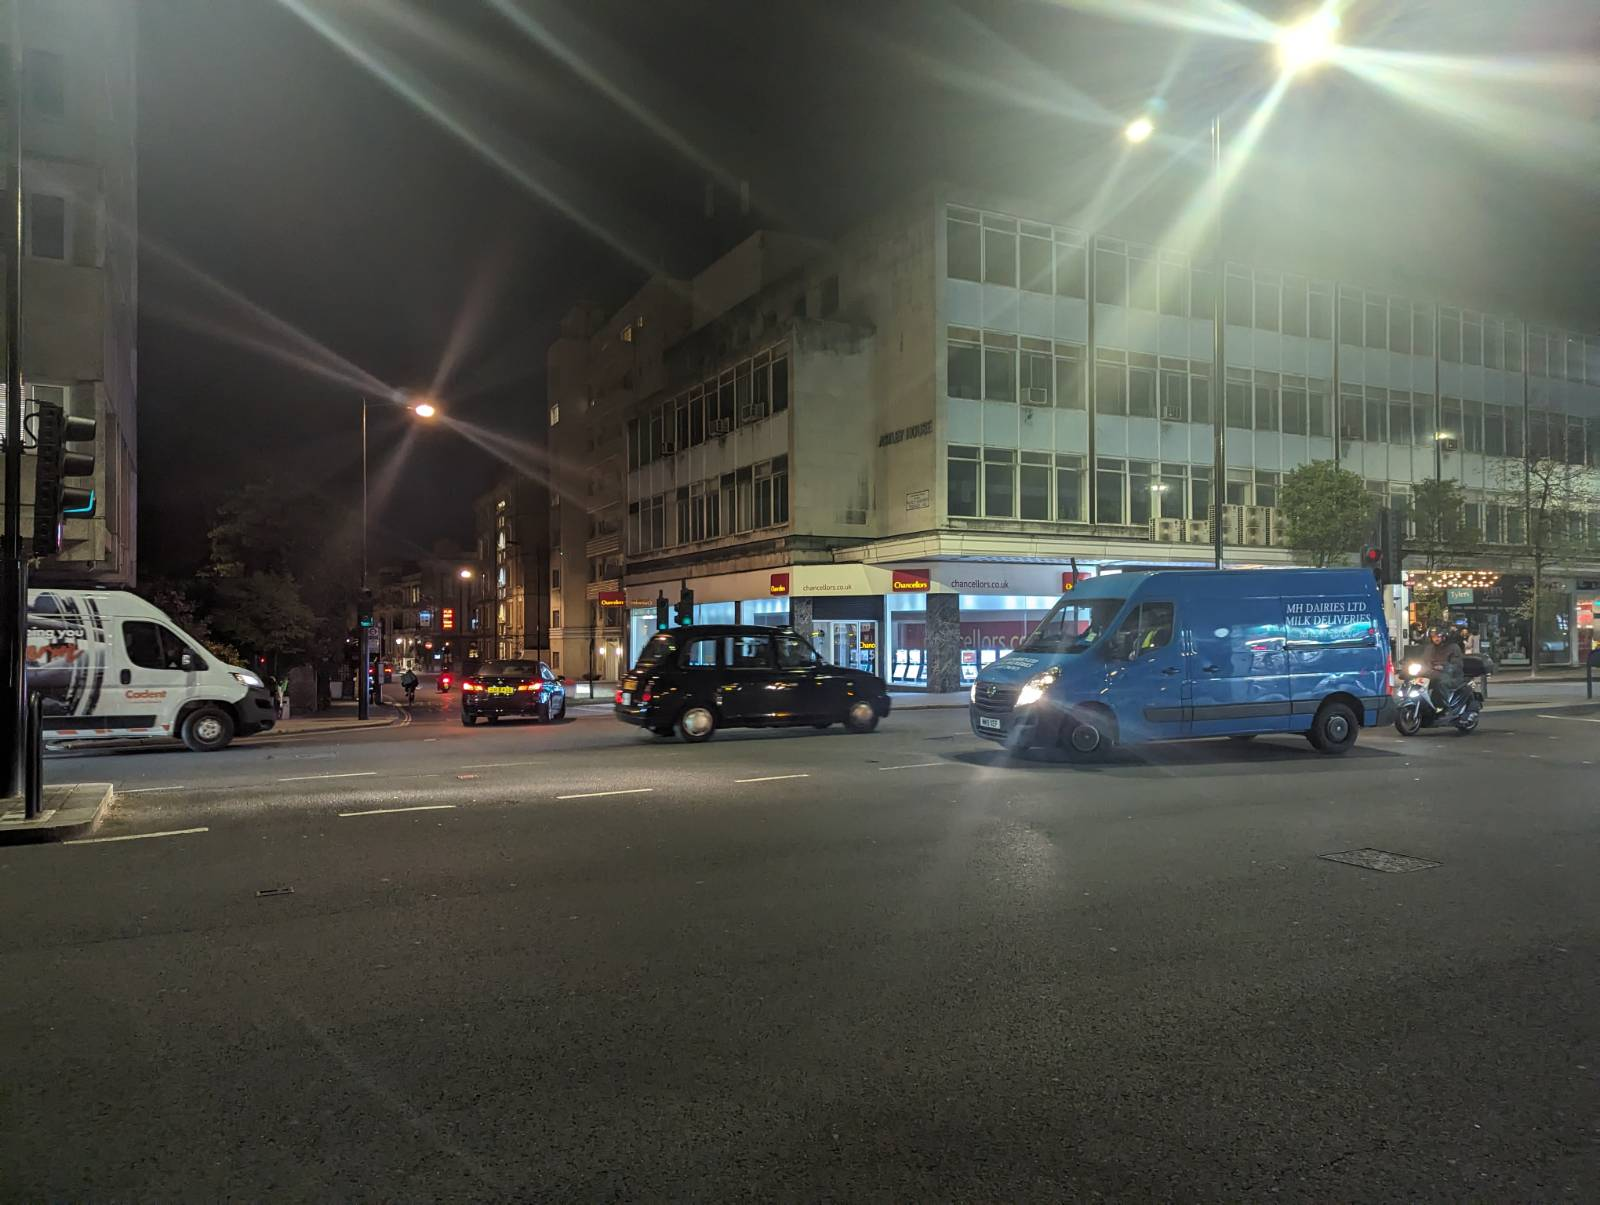

In [36]:
import pandas as pd
from pathlib import Path
seed = 3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
# Specify the directory path


from PIL import Image, ExifTags
from PIL.ExifTags import TAGS

from IPython.display import display
# img = Image.open(f"mappilary/train_val/{place}/database/images/{df['key'][sample]}.jpg")
img = Image.open("../sampleImages/sign4.jpeg")
           
display(img)

import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
def crop_image(image, x, y, w, h):
    """Crops an image using the provided coordinates.

    Args:
        image (Image): The PIL Image object to crop.
        x (int): The x-coordinate of the top-left corner of the crop region.
        y (int): The y-coordinate of the top-left corner of the crop region.
        w (int): The width of the crop region.
        h (int): The height of the crop region.

    Returns:
        Image: The cropped PIL Image object.
    """

    box = (x, y, x + w, y + h)  # Create the crop box tuple
    cropped_image = image.crop(box)
    return cropped_image



In [37]:
# reader.readtext( np.array(img), text_threshold=0.1, low_text=0.1, min_size=5)

In [38]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# load image from the IAM database (actually this model is meant to be used on printed text)
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')
# pixel_values = processor(images=image, return_tensors="pt").pixel_values

# generated_ids = model.generate(pixel_values)
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def run_text_extraction_hybrid(x,y,w,h):
    textSeg = crop_image(img,x,y,w,h)
    fig, ax = plt.subplots(figsize=(15, 10))
    res = reader.readtext(np.array(textSeg),  min_size=5, mag_ratio=2, text_threshold=0.5, low_text=0.3)

    for bbox, text, confidence in res:
        # Extract coordinates (assuming top-left is the origin)
        top_left = bbox[0]
        bottom_right = bbox[2]

        # Create a rectangle patch
        rect = mpatches.Rectangle(xy=top_left, 
                                  width=bottom_right[0] - top_left[0],
                                  height=bottom_right[1] - top_left[1],
                                  linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the plot
        ax.add_patch(rect)

        # Add the text label near the bounding box
        bbox_image = crop_image(textSeg, top_left[0], top_left[1], bottom_right[0] - top_left[0], bottom_right[1] - top_left[1])
        pixel_values = processor(images=bbox_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        ax.text(top_left[0], top_left[1], f'{generated_text} ({text}-{confidence:.2f})', 
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    ax.imshow(textSeg)  

    plt.show()
    return res



In [40]:
np.array(img).shape

(1205, 1600, 3)

In [42]:
# run_text_extraction_hybrid(0,0,1600,1205)

`label_ids_to_fuse` unset. No instance will be fused.
/var/tmp/pbs.9228811.pbs/ipykernel_3905368/2098742959.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis =    matplotlib.cm.get_cmap('viridis', torch.max(segmentation) ) #cm.get_cmap('viridis', )


{'id': 1, 'label_id': 21, 'was_fused': False, 'score': 0.953011}
(0.279566, 0.067836, 0.391917, 1.0)
{'id': 2, 'label_id': 17, 'was_fused': False, 'score': 0.999824}
(0.283072, 0.130895, 0.449241, 1.0)
{'id': 3, 'label_id': 57, 'was_fused': False, 'score': 0.989386}
(0.277134, 0.185228, 0.489898, 1.0)
{'id': 4, 'label_id': 55, 'was_fused': False, 'score': 0.534046}
(0.262138, 0.242286, 0.520837, 1.0)
{'id': 5, 'label_id': 45, 'was_fused': False, 'score': 0.972579}
(0.241237, 0.296485, 0.539709, 1.0)
{'id': 6, 'label_id': 2, 'was_fused': False, 'score': 0.993354}
(0.220057, 0.343307, 0.549413, 1.0)
{'id': 7, 'label_id': 35, 'was_fused': False, 'score': 0.649396}
(0.197636, 0.391528, 0.554969, 1.0)
{'id': 8, 'label_id': 19, 'was_fused': False, 'score': 0.681737}
(0.177423, 0.437527, 0.557565, 1.0)
{'id': 9, 'label_id': 24, 'was_fused': False, 'score': 0.986629}
(0.160665, 0.47854, 0.558115, 1.0)
{'id': 10, 'label_id': 45, 'was_fused': False, 'score': 0.94817}
(0.143343, 0.522773, 0.55629

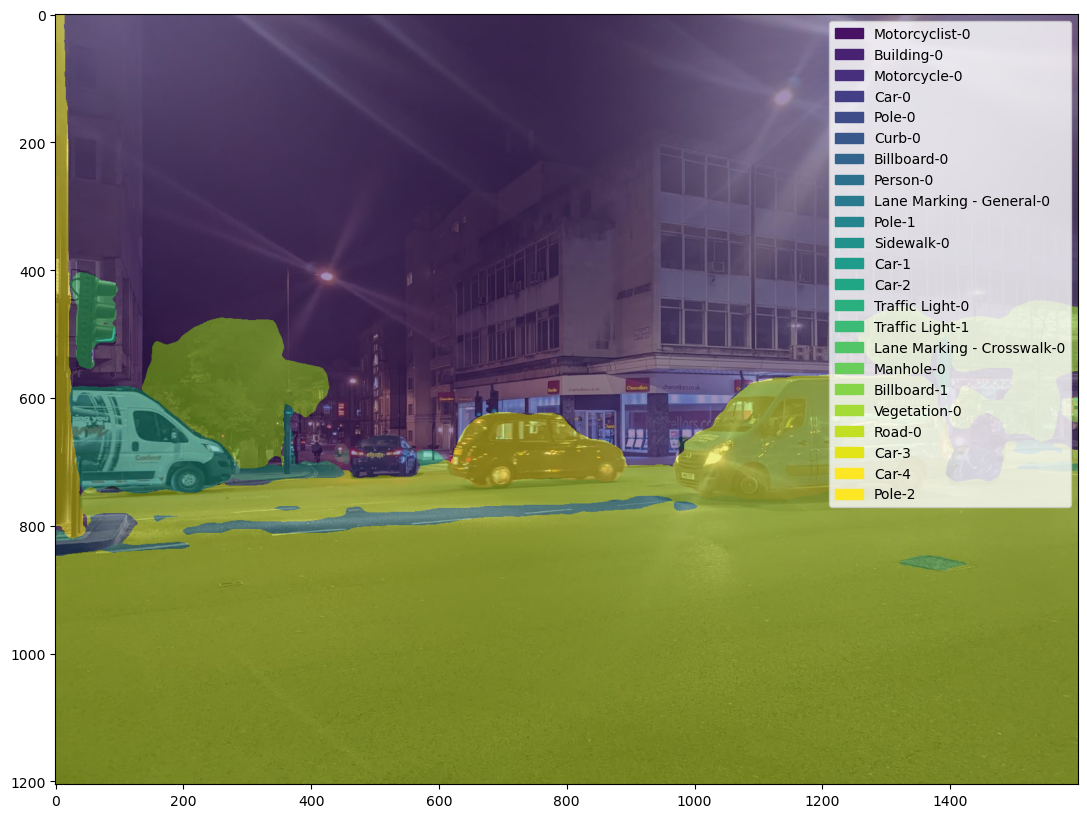

In [43]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

import torch

# Load Mask2Former trained on CityScapes panoptic segmentation dataset
seg_image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-panoptic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-mapillary-vistas-panoptic"
)

# # Load Mask2Former trained on CityScapes panoptic segmentation dataset
# seg_image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")
# seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(
#     "facebook/mask2former-swin-large-cityscapes-panoptic"
# )

seg_inputs = seg_image_processor(img, return_tensors="pt")

with torch.no_grad():
    seg_outputs = seg_model(**seg_inputs)

# Model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = seg_outputs.class_queries_logits
masks_queries_logits = seg_outputs.masks_queries_logits


from collections import defaultdict

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
 
    viridis =    matplotlib.cm.get_cmap('viridis', torch.max(segmentation) ) #cm.get_cmap('viridis', )
    fig, ax = plt.subplots(figsize=(15, 10))

#     palette = np.array(ade_palette())
    color_seg = np.zeros((segmentation.shape[0], segmentation.shape[1], 3)) # height, width, 3
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        print(segment)
        segment_label_id = segment['label_id']
        segment_label = seg_model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        print(color)
        color_seg[np.array(segmentation) == segment_id, :] = np.array( [color[0], color[1], color[2]]) # color[0:-1]

        handles.append(mpatches.Patch(color=color, label=label))
    print(color_seg.shape)
    print(color_seg.max())
    ax.imshow((np.array(img)/510 + np.array(color_seg) /2) )   
    ax.legend(handles=handles)
#     return fig
pred_panoptic_map = seg_image_processor.post_process_panoptic_segmentation(
    seg_outputs, target_sizes=[img.size[::-1]]
)[0]
draw_panoptic_segmentation(**pred_panoptic_map)

1 Motorcyclist
2 Building
3 Motorcycle
4 Car
5 Pole
6 Curb
7 Billboard
8 Person
9 Lane Marking - General
10 Pole
11 Sidewalk
12 Car
13 Car
14 Traffic Light
15 Traffic Light
16 Lane Marking - Crosswalk
17 Manhole
18 Billboard
19 Vegetation
20 Road
21 Car
22 Car
23 Pole


/var/tmp/pbs.9228811.pbs/ipykernel_3905368/1651869797.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis =    matplotlib.cm.get_cmap('viridis', torch.max(segmentation) ) #cm.get_cmap('viridis', )


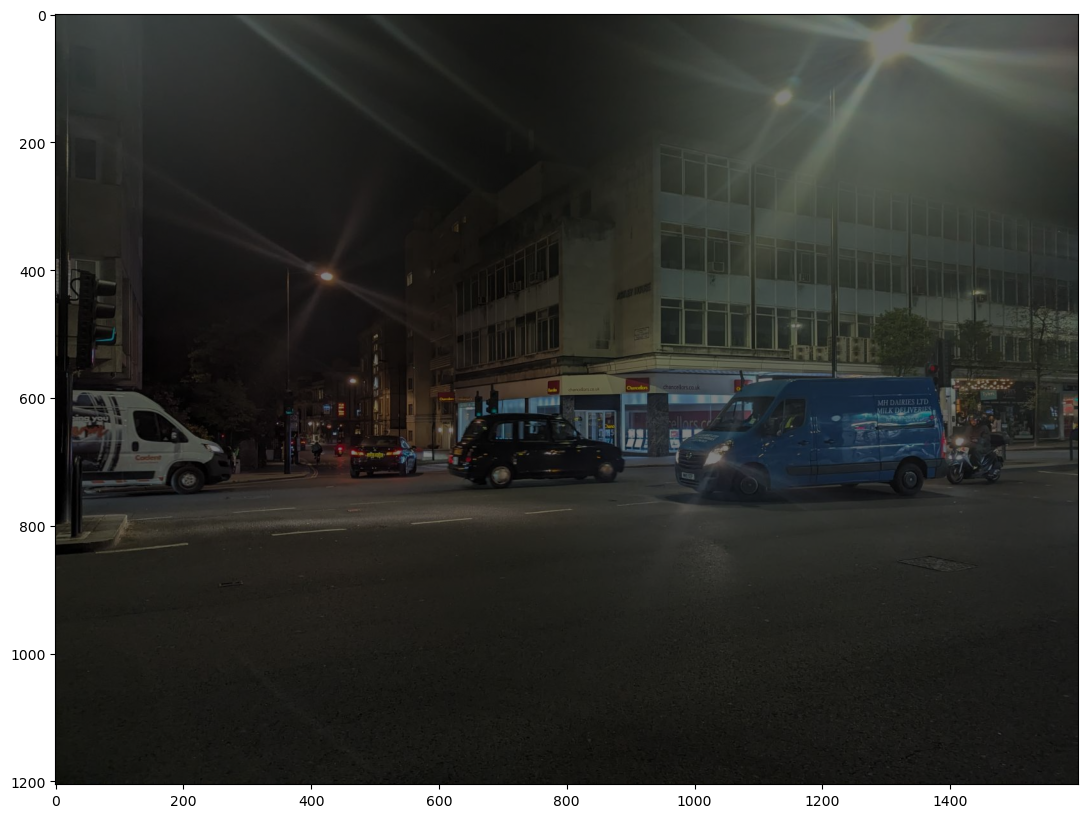

In [44]:
def show_segment(interest,segments_info,segmentation):
    for seg in segments_info:
        print(seg["id"], seg_model.config.id2label[seg["label_id"]])
        if seg_model.config.id2label[seg["label_id"]] == interest:
            print("found")
    viridis =    matplotlib.cm.get_cmap('viridis', torch.max(segmentation) ) #cm.get_cmap('viridis', )
    fig, ax = plt.subplots(figsize=(15, 10))

    color_seg = np.zeros((segmentation.shape[0], segmentation.shape[1], 3)) # height, width, 3
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        if seg_model.config.id2label[segment["label_id"]] == interest:
            segment_id = segment['id']
            color_seg[np.array(segmentation) == segment_id, :] = np.array( [1,0,1]) # color[0:-1]

    ax.imshow((np.array(img)/510 + np.array(color_seg) /2) )   
show_segment("Traffic Sign (Front)",pred_panoptic_map["segments_info"],pred_panoptic_map["segmentation"])

1 Motorcyclist
2 Building
3 Motorcycle
4 Car
5 Pole
6 Curb
7 Billboard
found
8 Person
9 Lane Marking - General
10 Pole
11 Sidewalk
12 Car
13 Car
14 Traffic Light
15 Traffic Light
16 Lane Marking - Crosswalk
17 Manhole
18 Billboard
found
19 Vegetation
20 Road
21 Car
22 Car
23 Pole


/var/tmp/pbs.9228811.pbs/ipykernel_3905368/1651869797.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis =    matplotlib.cm.get_cmap('viridis', torch.max(segmentation) ) #cm.get_cmap('viridis', )


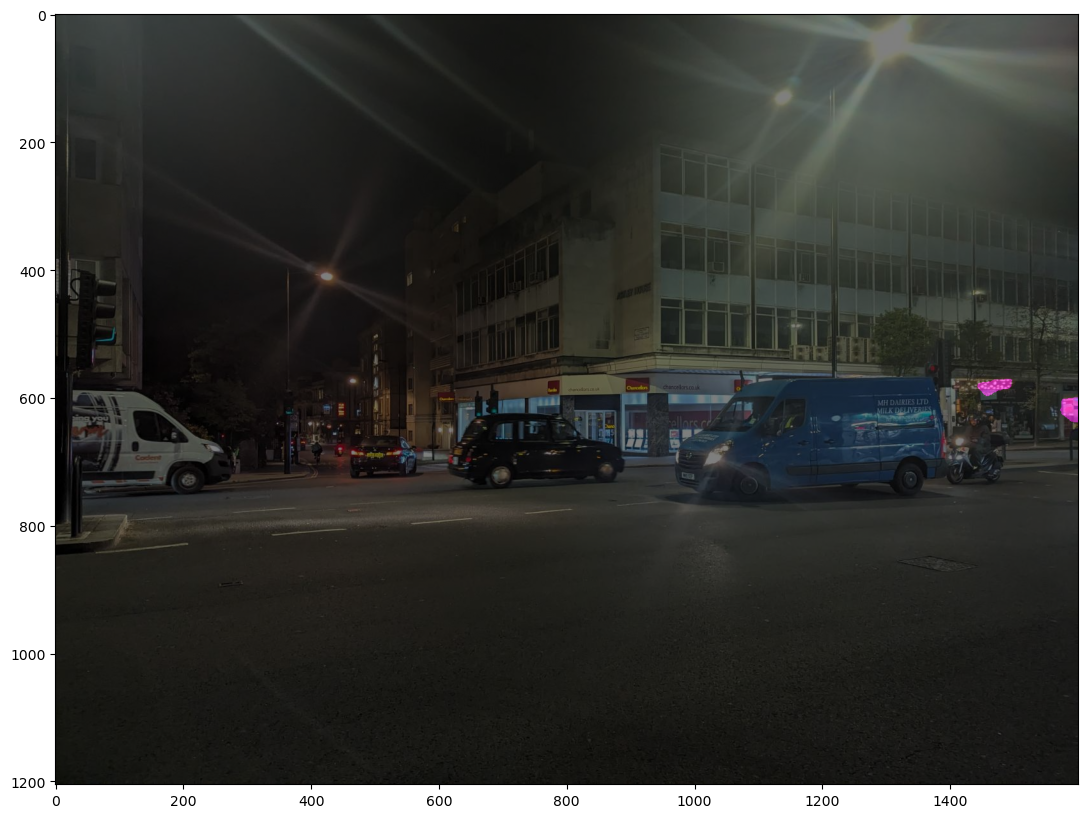

In [45]:

show_segment("Billboard",pred_panoptic_map["segments_info"],pred_panoptic_map["segmentation"])


1 Motorcyclist
2 Building
found
3 Motorcycle
4 Car
5 Pole
6 Curb
7 Billboard
8 Person
9 Lane Marking - General
10 Pole
11 Sidewalk
12 Car
13 Car
14 Traffic Light
15 Traffic Light
16 Lane Marking - Crosswalk
17 Manhole
18 Billboard
19 Vegetation
20 Road
21 Car
22 Car
23 Pole


/var/tmp/pbs.9228811.pbs/ipykernel_3905368/1651869797.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis =    matplotlib.cm.get_cmap('viridis', torch.max(segmentation) ) #cm.get_cmap('viridis', )


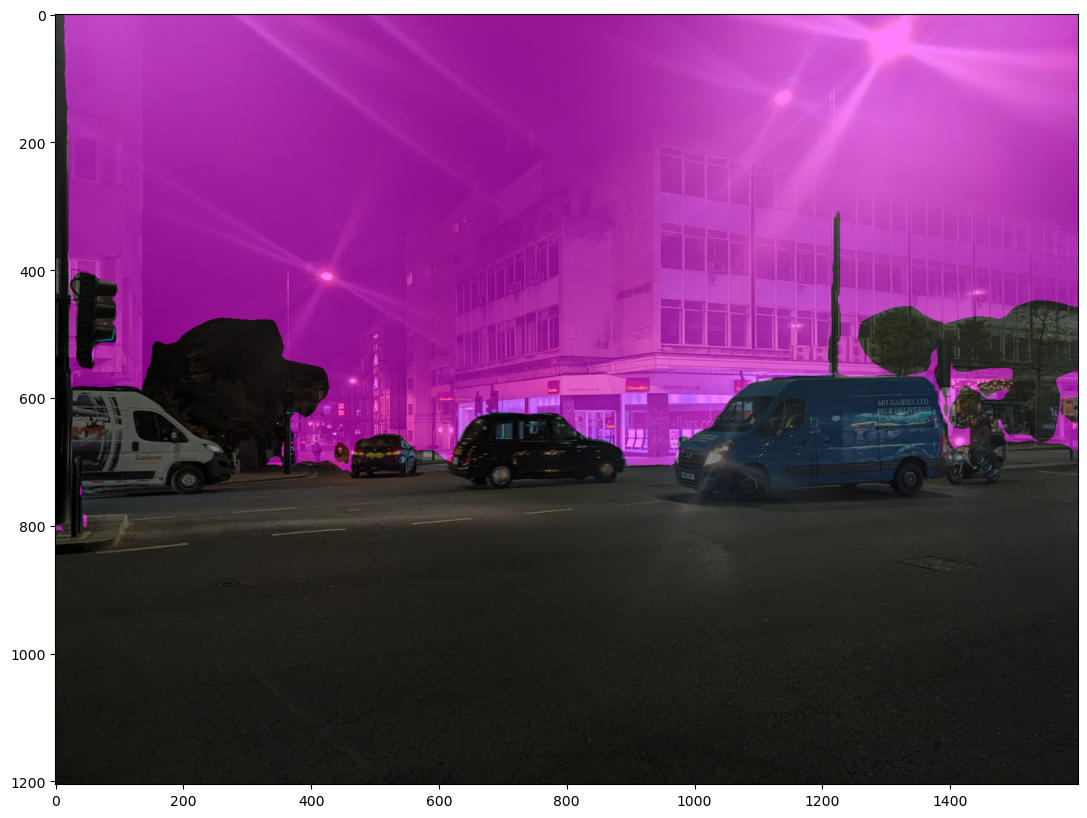

In [46]:
show_segment("Building",pred_panoptic_map["segments_info"],pred_panoptic_map["segmentation"])


In [21]:
def run_text_extraction(x,y,w,h):
    textSeg = crop_image(img,x,y,w,h)
    pixel_values = processor(images=textSeg, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(textSeg)  
    return generated_text

FURSBY AVENUE
Fursby Avenue, West Finchley, London Borough of Barnet, London, Greater London, England, N3 1PP, United Kingdom
(51.6120135, -0.1938858)


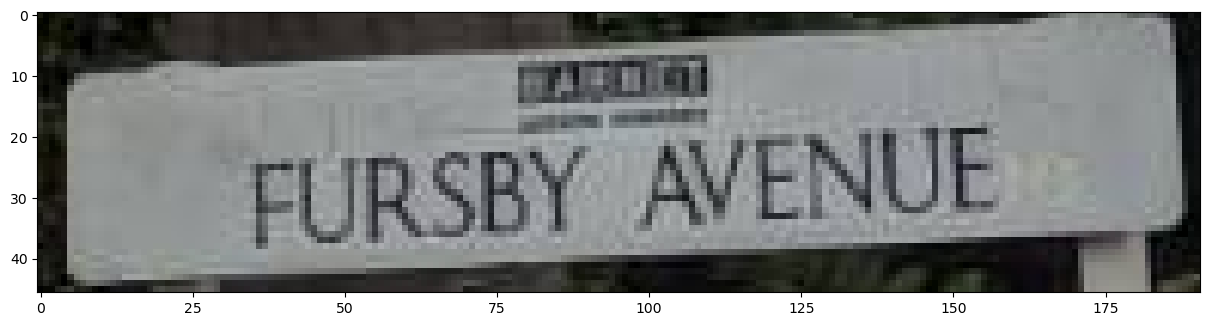

In [23]:
import numpy as np
import cv2
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Imperial College London")
mask = (pred_panoptic_map['segmentation'].numpy() == 24)
visual_mask = (mask * 255).astype(np.uint8)
# visual_mask = Image.fromarray(visual_mask)
# visual_mask
contours, hierarchy = cv2.findContours(visual_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)  
    text = run_text_extraction(x, y, w, h)
    location = geolocator.geocode(text)
    print(location.address)
    print((location.latitude, location.longitude))

https://www.google.com/maps/@51.609352,-0.1898328,3a,75y,9.64h,85.33t/data=!3m6!1e1!3m4!1spE7L87opjSyxt_K7yv1Asg!2e0!7i16384!8i8192?entry=ttu


FURSBY AVENUE
0.4080592351767337


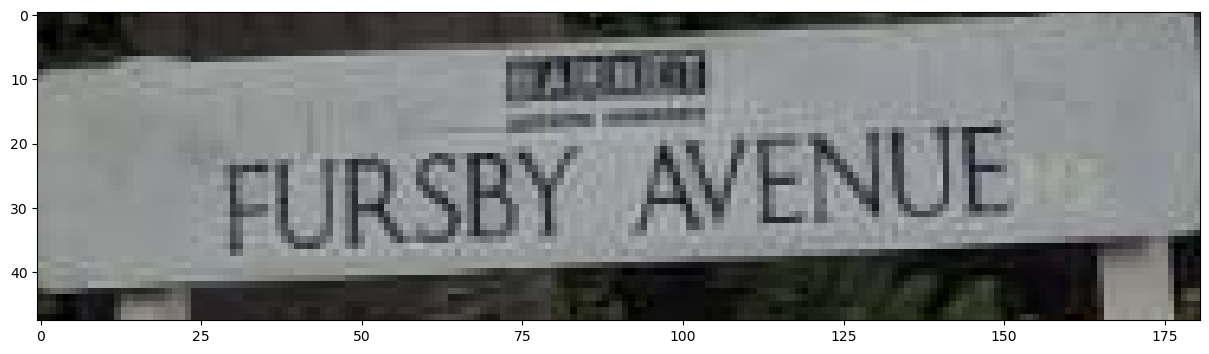

In [64]:
import folium
from geopy import distance

import folium.plugins as plugins
from folium.plugins import HeatMap

map_center=[51.609352,-0.1898328]
# mymap = folium.Map(location=map_center, zoom_start=10)
mymap = folium.Map(location=map_center, zoom_start=18)


# Add points to the map
count = 10
# for index, row in df.sample(n=count).iterrows():

folium.Marker(
    location=[51.609352,-0.1898328],
    tooltip="groundtruth",
    popup="Ground Truth",
    icon=folium.Icon(color="green"),
).add_to(mymap)

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)  
    text = run_text_extraction(x, y, w, h)
    location = geolocator.geocode(text)
    print(distance.distance((51.609352,-0.1898328), (location.latitude,location.longitude)).km)
    folium.Marker(location=[location.latitude,location.longitude],
                 popup=location.address).add_to(mymap)




tile = folium.TileLayer(
      tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
      attr = 'Esri',
      name = 'Esri Satellite',
      overlay = False,
      control = True
      ).add_to(mymap)
folium.LayerControl().add_to(mymap)  
mymap

In [57]:
def run_text_extraction_hybrid1(x, y, w, h):
    textSeg = crop_image(img, x, y, w, h)

    res = reader.readtext(np.array(textSeg), min_size=5, mag_ratio=2, text_threshold=0.5, low_text=0.5)

    for bbox, text, confidence in res:
        # Extract coordinates
        top_left = bbox[0]
        bottom_right = bbox[2]

        # Crop the bounding box region
        bbox_image = crop_image(textSeg, top_left[0], top_left[1], bottom_right[0] - top_left[0], bottom_right[1] - top_left[1])

        # Process cropped image for text recognition
        pixel_values = processor(images=bbox_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Create a figure for this bounding box
        fig, ax = plt.subplots()

        # Display the bounding box image
        ax.imshow(bbox_image)

        # Add text label
        ax.text(0, 0, f'{generated_text} ({confidence:.2f})',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

        plt.show()
    fig, ax = plt.subplots()

    ax.imshow(textSeg)
    plt.show()



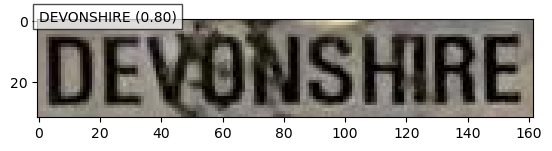

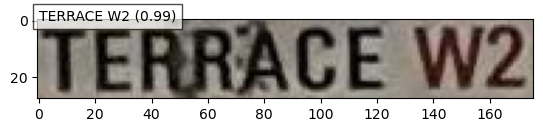

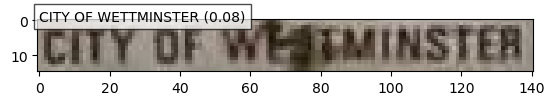

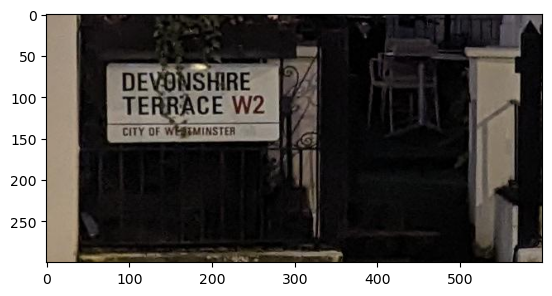

In [58]:
run_text_extraction_hybrid1(500,1400,600,300)

In [55]:
def run_text_extraction_hybrid(x=0,y=0,w=0,h=0):
    textSeg = crop_image(img,x,y,w,h)
    if x==0 and y==0 and w==0 and h==0:
        textSeg = img
    fig, ax = plt.subplots(figsize=(15, 10))
    res = reader.readtext(np.array(textSeg),  min_size=5, mag_ratio=1, text_threshold=0.7, low_text=0.4)

    for bbox, text, confidence in res:
        # Extract coordinates (assuming top-left is the origin)
        top_left = bbox[0]
        bottom_right = bbox[2]

        # Create a rectangle patch
        rect = mpatches.Rectangle(xy=top_left, 
                                  width=bottom_right[0] - top_left[0],
                                  height=bottom_right[1] - top_left[1],
                                  linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the plot
        ax.add_patch(rect)

        # Add the text label near the bounding box
        bbox_image = crop_image(textSeg, top_left[0], top_left[1], bottom_right[0] - top_left[0], bottom_right[1] - top_left[1])
        pixel_values = processor(images=bbox_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
#         ax.text(top_left[0], top_left[1], f'{generated_text} ({text}-{confidence:.2f})', 
#                 fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    ax.imshow(textSeg)  

    plt.show()
    return res


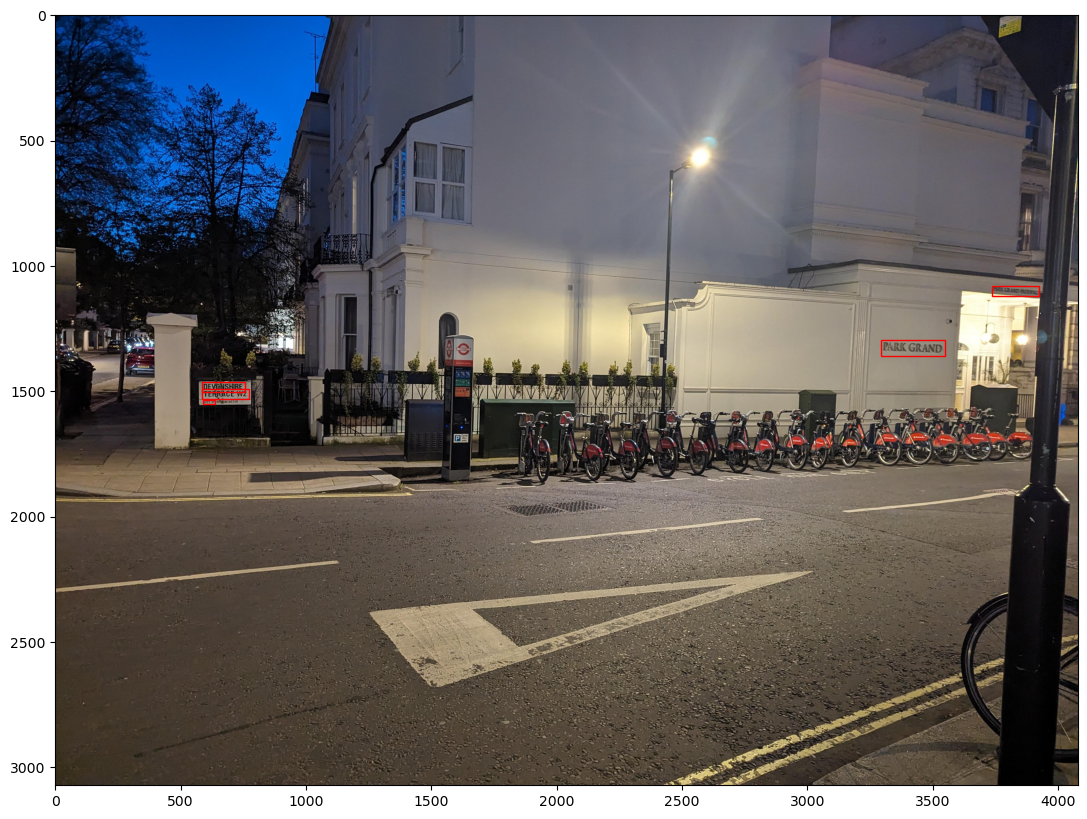

[([[3737, 1079], [3925, 1079], [3925, 1121], [3737, 1121]],
  'naRTTE',
  0.0072412592698427635),
 ([[3294, 1295], [3550, 1295], [3550, 1358], [3294, 1358]],
  'PARK GRAND',
  0.7779008744907285),
 ([[586, 1463], [755, 1463], [755, 1501], [586, 1501]],
  'DEVONSHIRE',
  0.995738243261278),
 ([[586, 1491], [771, 1491], [771, 1529], [586, 1529]],
  'TERRACE W2',
  0.9707892239708671),
 ([[591, 1535], [638, 1535], [638, 1550], [591, 1550]],
  'city 0F',
  0.35418441524717353)]

In [56]:
run_text_extraction_hybrid()

In [59]:
geolocator.geocode("PARK GRAND")

Location(Parkgränd, Övermark, Närpes, Sydösterbotten, Österbotten, Länsi- ja Sisä-Suomen aluehallintovirasto, Manner-Suomi, 64610, Suomi / Finland, (62.6053132, 21.4578565, 0.0))

In [60]:
geolocator.geocode("DEVONSHIRE TERRACE W2")

Location(Devonshire Terrace, Westbourne Green, Paddington, London, Greater London, England, W2 3DN, United Kingdom, (51.5140938, -0.1803957, 0.0))

In [64]:
geolocator.geocode("PARK GRAND").raw

{'place_id': 273599833,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 230384426,
 'lat': '51.504993400000004',
 'lon': '-0.14724925588630638',
 'class': 'tourism',
 'type': 'hotel',
 'place_rank': 30,
 'importance': 0.27234374910307113,
 'addresstype': 'tourism',
 'name': 'Sheraton Grand London Park Lane Hote',
 'display_name': "Sheraton Grand London Park Lane Hote, Piccadilly, St. James's, Mayfair, London, Greater London, England, W1J 7BX, United Kingdom",
 'boundingbox': ['51.5046740', '51.5052893', '-0.1479977', '-0.1467008']}

https://www.openstreetmap.org/way/230384426
https://www.openstreetmap.org/api/0.6/way/230384426/full